# Training Notebook

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

2025-12-03 21:04:40.474886: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 21:04:40.503146: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Dataset Preprocessing

In [4]:
chestdata = np.load('chestmnist.npz')

X_train=chestdata['train_images']
t_train=chestdata['train_labels']

X_valid=chestdata['val_images']
t_valid=chestdata['val_labels']

X_test=chestdata['test_images']
t_test=chestdata['test_labels']

X_train.shape, t_train.shape, X_valid.shape, t_valid.shape, X_test.shape, t_test.shape

((78468, 28, 28),
 (78468, 14),
 (11219, 28, 28),
 (11219, 14),
 (22433, 28, 28),
 (22433, 14))

In [5]:
class_names = np.array(['Atelectasis','Cardiomegaly','Effusion','Infiltration',
                        'Mass','Nodule','Pneumonia','Pneumothorax','Consolidation',
                        'Edema (Oedema)','Emphysema','Fibrosis','Pleural Thickening',
                        'Hernia'])

Because Tensorflow CNNs expect 4 dimensions (Batch, Height, Width, Channel) and the data is (N, 28, 28) a grayscale channel dimension must be added to make it (N, 28, 28, 1). Furthermore the data must also be normalized.

In [6]:
X_train = X_train.astype('float32') / 255.0
X_valid = X_valid.astype('float32') / 255.0

X_train = np.expand_dims(X_train, axis=-1)
X_valid = np.expand_dims(X_valid, axis=-1)

print(f"Training shape: {X_train.shape}")
print(f"Validation shape: {X_valid.shape}")

Training shape: (78468, 28, 28, 1)
Validation shape: (11219, 28, 28, 1)


In [8]:
total_samples = len(t_train)
counts = np.sum(t_train, axis=0)
percentages = (counts / total_samples) * 100

print(f"\nTotal Training Samples: {total_samples}")
print("-" * 50)
print(f"{'Disease':<20} | {'Count':<10} | {'Percentage':<10}")
print("-" * 50)
for i, name in enumerate(class_names):
    print(f"{name:<20} | {counts[i]:<10} | {percentages[i]:.2f}%")
print("-" * 50)



Total Training Samples: 78468
--------------------------------------------------
Disease              | Count      | Percentage
--------------------------------------------------
Atelectasis          | 7996       | 10.19%
Cardiomegaly         | 1950       | 2.49%
Effusion             | 9261       | 11.80%
Infiltration         | 13914      | 17.73%
Mass                 | 3988       | 5.08%
Nodule               | 4375       | 5.58%
Pneumonia            | 978        | 1.25%
Pneumothorax         | 3705       | 4.72%
Consolidation        | 3263       | 4.16%
Edema (Oedema)       | 1690       | 2.15%
Emphysema            | 1799       | 2.29%
Fibrosis             | 1158       | 1.48%
Pleural Thickening   | 2279       | 2.90%
Hernia               | 144        | 0.18%
--------------------------------------------------


3 disease classes account for roughly 40% of the entire dataset samples indicating heavy class imbalance which may affect model predicitve ability later.

## CNN Architecture

In [16]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),

    keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),

    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5), # Regularization

    keras.layers.Dense(14, activation='sigmoid') 
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.5),
        keras.metrics.AUC(multi_label=True, name='auc')
    ]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 392,334 (1.50 MB)

 Trainable params: 391,886 (1.49 MB)

 Non-trainable params: 448 (1.75 KB)

### Callbacks

In [18]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "model_dataset1.keras", 
    save_best_only=True, 
    monitor='val_auc', 
    mode='max',
    verbose=1
)

early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    patience=10, 
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc', 
    factor=0.2, 
    patience=3, 
    min_lr=1e-6,
    mode='max',
    verbose=1
)

history = model.fit(
    X_train, t_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_valid, t_valid),
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb],
    verbose=1
)

Epoch 1/50
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.5779 - binary_accuracy: 0.9427 - loss: 0.2068
Epoch 1: val_auc improved from -inf to 0.64593, saving model to model_dataset1.keras
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - auc: 0.5779 - binary_accuracy: 0.9427 - loss: 0.2068 - val_auc: 0.6459 - val_binary_accuracy: 0.9492 - val_loss: 0.1811 - learning_rate: 0.0010
Epoch 2/50
1217/1227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6325 - binary_accuracy: 0.9482 - loss: 0.1789
Epoch 2: val_auc improved from 0.64593 to 0.68606, saving model to model_dataset1.keras
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - auc: 0.6326 - binary_accuracy: 0.9482 - loss: 0.1789 - val_auc: 0.6861 - val_binary_accuracy: 0.9492 - val_loss: 0.1701 - learning_rate: 0.0010
Epoch 3/50
1222/1227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6598 - binary_accuracy: 0.9487 - loss: 0.1737
Epoch 3: val_auc improved from 0.68606 to 0.70387, saving model to model_dataset1.keras
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 2s

50 epochs were not needed. After 10 epochs of training, model gains plateued. The model from epoch 10 was saved. It had the following performance results: 

| Metric               | Value    |
|----------------------|----------|
| Training AUC                 | 0.7465   |
| Training Binary Accuracy      | 0.9487   |
| Traning Loss                 | 0.1621   |
| Validation AUC             | 0.7271   |
| Validation Binary Accuracy  | 0.9493   |
| Validation Loss             | 0.1634   |
| learning Rate       | 0.0010   |


## Learning Curves

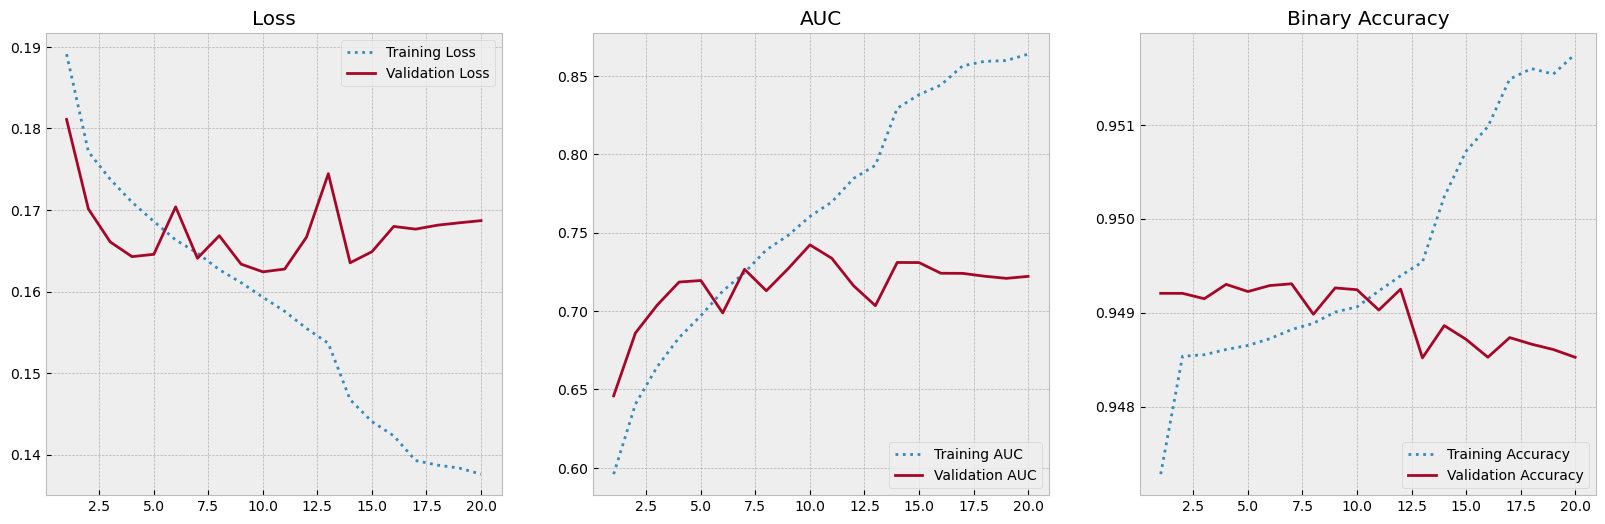

In [21]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
auc = history.history['auc']
val_auc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(20, 6))


plt.subplot(1, 3, 1)
plt.plot(epochs_range, loss, label='Training Loss', linestyle=':', linewidth=2)
plt.plot(epochs_range, val_loss, label='Validation Loss', linestyle='-', linewidth=2)
plt.title('Loss')
plt.legend()
plt.grid(True)


plt.subplot(1, 3, 2)
plt.plot(epochs_range, auc, label='Training AUC', linestyle=':', linewidth=2)
plt.plot(epochs_range, val_auc, label='Validation AUC', linestyle='-', linewidth=2)
plt.title('AUC')
plt.legend(loc='lower right')
plt.grid(True)


plt.subplot(1, 3, 3)
plt.plot(epochs_range, acc, label='Training Accuracy', linestyle=':', linewidth=2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linestyle='-', linewidth=2)
plt.title('Binary Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

As seen above, most performance curves platued or dropped significantly after epoch 10, which was the mdoel saved. Improvements in the performance curves for traning data with decrease in performance for validation data may indicate overfitting although for for binary accuracy and loss curves this difference is relatively small. 